In [18]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision, BinaryAccuracy, CategoricalAccuracy, CategoricalCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy

from skimage import morphology
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorboard 
import datetime
from tensorflow.keras.utils import plot_model

import json
from skimage import io
from pathlib import Path


### Overview
Let's test whether we can build a model and memorize training data. The dataset is small and the model should be able to memorize it pretty effectively. This will be a good proof of concept to verify I got my shit together.

This process is "inspired" by the blog at https://idiotdeveloper.com/unet-segmentation-with-pretrained-mobilenetv2-as-encoder/#comment-299

and informed by https://www.tensorflow.org/tutorials/images/segmentation

In [2]:
# some model and tf.dataset args
DEFAULT_IMAGE_SIZE = [512, 512, 3]
DEFAULT_EPOCHS = 100
DEFAULT_BATCH = 8
DEFAULT_LR = 0.01
DEFAULT_MOMENTUM = 0.1
DEFAULT_MODEL_WIDTH_ALPHA = 0.5
DEFAULT_NUM_CLASSES = 3
DEFAULT_RESIDUAL_LAYER_NAMES = ['input_image',   
                                'block_1_expand_relu',   # 64x64
                                'block_3_expand_relu',   # 32x32
                                'block_6_expand_relu']   # 16x16
DEFAULT_RESIDUAL_LAYER_CHANNELS =  [16, 32, 48, 64]

In [3]:
# let's reuse our janky image read methods
def read_data(path, float_convert=True, scale_fctr=255., return_3D=True):
    # type enforcement for consistency
    if not isinstance(path, (Path, str)):
        path = path.decode()
    if float_convert:
        data = _read_float(path, scale_fctr)
    else:
        data = _read_u8(path, scale_fctr)
    if return_3D:
        data = np.atleast_3d(data)
    return data

def _read_float(path, scale_fctr=1.):
    x = io.imread(path) / scale_fctr
    return x.astype('float32') 

def _read_u8(path, scale_fctr=1):
    x = io.imread(path) / scale_fctr
    return x.astype('uint8')

In [4]:
def make_binary_boundary(y, width=2):
    y_bd = morphology.dilation(y[:, :, 0], morphology.square(width*2+1))
    return np.atleast_3d(y_bd) - y

In [5]:
def tf_parse(x, y, image_size=DEFAULT_IMAGE_SIZE[0], num_classes=DEFAULT_NUM_CLASSES):
    def _parse(x, y):
        x = read_data(x, True)
        y = read_data(y, True, 255.)
        if num_classes == 3:
            # dilate mask to make boundary
            y_bd = make_binary_boundary(y) * 10# possible option here to apply weight
            y = np.concatenate((y, y_bd), axis=2) # append boundary class
        if num_classes > 1:
            # define bg as absence of other classes
            y_bg = np.atleast_3d(np.logical_not(np.any(y>0, axis=2)))
            y = np.concatenate((y, y_bg), axis=2)
        return x, y
    
    # NOTE: need to be careful, not 100% what these are doing
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([image_size, image_size, 3])
    y.set_shape([image_size, image_size, num_classes])
    return x, y

def tf_dataset(x, y, batch=DEFAULT_BATCH):
    # NOTE: need to be careful, not 100% what these are doing
    print()
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()

    return dataset

In [6]:
# Let's define some params and load our training set
IMG_PATH_KEY, MSK_PATH_KEY, CLASS_KEY = 'images', 'masks', 'building'
data_dir = Path('C:/Users/NPDan/Documents/GitHub/task_challenge/data')

# get that df yo
train_df_path = data_dir / 'train_df.json'
train_df = pd.read_json(train_df_path)
valid_df_path = data_dir / 'valid_df.json'
valid_df = pd.read_json(valid_df_path)
test_df_path = data_dir / 'test_df.json'
test_df = pd.read_json(test_df_path)
# sanity check
# train_df[IMG_PATH_KEY].unique(), train_df[MSK_PATH_KEY].unique()

In [7]:
train_x = sorted([str(p) for p in Path(train_df[CLASS_KEY].unique()[0].replace('masks','images')).glob('*.png')])
train_y = sorted([str(p) for p in Path(train_df[CLASS_KEY].unique()[0]).glob('*.png')])
valid_x = sorted([str(p) for p in Path(valid_df[CLASS_KEY].unique()[0].replace('masks','images')).glob('*.png')])
valid_y = sorted([str(p) for p in Path(valid_df[CLASS_KEY].unique()[0]).glob('*.png')])
test_x = sorted([str(p) for p in Path(test_df[CLASS_KEY].unique()[0].replace('masks','images')).glob('*.png')])
test_y = sorted([str(p) for p in Path(test_df[CLASS_KEY].unique()[0]).glob('*.png')])

# Maybe follow this protocol ? https://github.com/keras-team/keras/issues/3653
sample_weights = np.zeros((len(train_y), DEFAULT_NUM_CLASSES))
sample_weights[:, 0] = 1 # background class
sample_weights[:, 1] = 2 # building class
sample_weights[:, 2] = 100 # boundary class


train_dataset = tf_dataset(train_x, train_y, batch=DEFAULT_BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=DEFAULT_BATCH)

In [8]:
valid_dataset.element_spec

(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None))

Those data loaders and data set methods look good. 

Now, let's try this whole model building thing...

In [9]:
def MobileNetV2_UNet(img_size: list=DEFAULT_IMAGE_SIZE, width_alpha: float=1.,
                     residual_layer_names: list=DEFAULT_RESIDUAL_LAYER_NAMES,
                     residual_layer_channels: list=DEFAULT_RESIDUAL_LAYER_CHANNELS,
                     output_channels=2):
    # defines model input single sample shape
    inputs = Input(shape=img_size, name="input_image")
    
    # Let's breakdown this really quick:
    #     input_shape -> defines input sample size
    #     input_tensor -> optional arg also specifies input sample size
    #     weights -> indicates to use pretrained weights from imagenet
    #     include_top -> indicates whether to retain FCN from original
    #     alpha -> controls network "width", controls filter scaling down the network
    #     encoder_output -> top layer of encoder to start decode path
    encoder = MobileNetV2(input_shape=img_size, input_tensor=inputs, weights="imagenet",
                          include_top=False, alpha=width_alpha)
        
    # ensure to lock encoder weights, get output
    encoder.trainable = False
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    #  build decode path from the bottom-up
    x = encoder_output
    for i in range(1, len(residual_layer_names)+1, 1):
        # Upconv (scales input tensor up by 2x2) and concatenate residual layer (x_skip)
        x_skip = encoder.get_layer(residual_layer_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        # apply 3x3 conv, preserve size (padding="same"), normalize and activate
        x = Conv2D(residual_layer_channels[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        # apply 3x3 conv, preserve size (padding="same"), normalize and activate
        x = Conv2D(residual_layer_channels[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
    # top-level FCN (1x classes conv) and activation
    x = Conv2DTranspose(output_channels, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [10]:
# original UNet used Dice-coefficient as the loss metric
DEFAULT_SMOOTH_EPS = 1e-15 # avoid divide by zero issues
def dice_coef(y_true, y_pred, smooth=DEFAULT_SMOOTH_EPS):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred, smooth=DEFAULT_SMOOTH_EPS):
    # flatten, calculate IoU and return
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(tf.maximum(y_true + y_pred, 1.)) # clip to 1.
    return intersection / (union + smooth)


In [11]:
def visualize_image_and_mask(x_img, y_true=None, y_pred=None,
                             mask_cmap_name='winter', show_axis=True, title_prefix = ''):
    # plot original
    fig = plt.figure()
    plt.subplot(1,2,1)
    if y_true is not None:
        # overlay mask if applicable
        y_true = y_true.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Truth')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_true, alpha=0.4*y_true, vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
    else:
        plt.title(' '.join((title_prefix, 'Image')))
        plt.imshow(x_img)
    if not show_axis:
        plt.axis('off')
        
    # plot augmented
    if y_pred is not None:
        plt.subplot(1,2,2)
        # overlay mask if applicable
        y_pred = y_pred.squeeze()
        plt.title(' '.join((title_prefix, 'Image + Predicted')))
        plt.imshow(x_img, vmin=0, vmax=1)
        plt.imshow(y_pred, alpha=0.4*y_pred.squeeze(), vmin=0, vmax=1,
                   cmap=plt.get_cmap(mask_cmap_name))
        if not show_axis:
            plt.axis('off')
    plt.show()


That looks good, let's now define some loss and optimizer components

And here we go... Let's instantiate the model

In [12]:
# setting monitor = loss should track the training loss, but for reference I've duplicated the
# training data as validation set
# changing patience to hopefully expediite memorization
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=2 ),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta = 0.001),
]

# SET training steps
train_steps = len(train_x)//DEFAULT_BATCH
valid_steps = len(train_x)//DEFAULT_BATCH
if len(train_x) % DEFAULT_BATCH != 0:
    train_steps += 1
if len(train_x) % DEFAULT_BATCH != 0: # train and validation set are the same
    valid_steps += 1

In [13]:
opt = tf.keras.optimizers.Adam(DEFAULT_LR)# Blog used - tf.keras.optimizers.Nadam(DEFAULT_LR)
metrics = [CategoricalAccuracy(), Recall(), Precision()]
model_diceLoss = MobileNetV2_UNet(output_channels=DEFAULT_NUM_CLASSES)
model_diceLoss.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

# Getting warning because mobilenet doesn't like 512x512 images... Let's see how it goes

Set up some training callbacks to improve training and define some train-loop parameters and then, let 'er rip

In [14]:

################### Maybe follow this protocol for sample weights ? https://github.com/keras-team/keras/issues/3653
model_diceLoss.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=DEFAULT_EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks, 
)

Epoch 1/100
21/21 [==============================] - 17s 535ms/step - loss: 0.4493 - categorical_accuracy: 0.4947 - recall: 0.7218 - precision: 0.4906 - val_loss: 0.3277 - val_categorical_accuracy: 0.3125 - val_recall: 0.8946 - val_precision: 0.4975
Epoch 2/100
21/21 [==============================] - 9s 429ms/step - loss: 0.1914 - categorical_accuracy: 0.8583 - recall: 0.8938 - precision: 0.7841 - val_loss: 0.4454 - val_categorical_accuracy: 0.4580 - val_recall: 0.7883 - val_precision: 0.3985
Epoch 3/100
21/21 [==============================] - 9s 431ms/step - loss: 0.1277 - categorical_accuracy: 0.8791 - recall: 0.8977 - precision: 0.8373 - val_loss: 0.6312 - val_categorical_accuracy: 0.2702 - val_recall: 0.3678 - val_precision: 0.3171
Epoch 4/100
21/21 [==============================] - 9s 429ms/step - loss: 0.1023 - categorical_accuracy: 0.8947 - recall: 0.9106 - precision: 0.8576 - val_loss: 0.5334 - val_categorical_accuracy: 0.3116 - val_recall: 0.4969 - val_precision: 0.3836
Epo

Epoch 34/100
21/21 [==============================] - 9s 426ms/step - loss: 0.0213 - categorical_accuracy: 0.9512 - recall: 0.9620 - precision: 0.9388 - val_loss: 0.0614 - val_categorical_accuracy: 0.9285 - val_recall: 0.9388 - val_precision: 0.9168
Epoch 35/100
21/21 [==============================] - 9s 426ms/step - loss: 0.0212 - categorical_accuracy: 0.9512 - recall: 0.9621 - precision: 0.9388 - val_loss: 0.0613 - val_categorical_accuracy: 0.9285 - val_recall: 0.9388 - val_precision: 0.9168
Epoch 36/100
21/21 [==============================] - 9s 425ms/step - loss: 0.0212 - categorical_accuracy: 0.9512 - recall: 0.9621 - precision: 0.9388 - val_loss: 0.0613 - val_categorical_accuracy: 0.9285 - val_recall: 0.9388 - val_precision: 0.9168
Epoch 37/100
21/21 [==============================] - 9s 426ms/step - loss: 0.0212 - categorical_accuracy: 0.9512 - recall: 0.9621 - precision: 0.9388 - val_loss: 0.0612 - val_categorical_accuracy: 0.9284 - val_recall: 0.9388 - val_precision: 0.9167


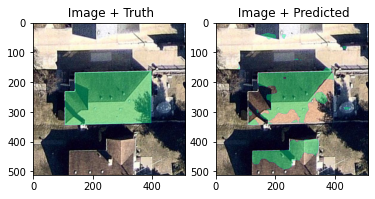

MeanIoU: 0.439  Precision: 0.676  Recall: 0.557  F1: 0.611


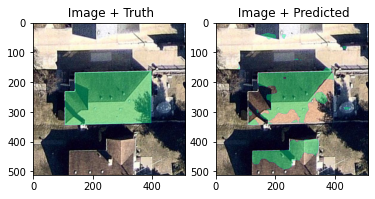

MeanIoU: 0.439  Precision: 0.676  Recall: 0.557  F1: 0.611


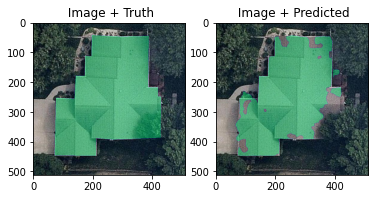

MeanIoU: 0.815  Precision: 0.981  Recall: 0.828  F1: 0.898


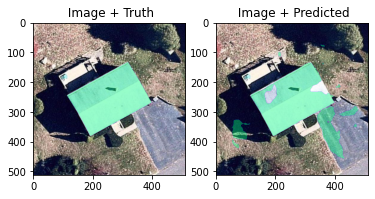

MeanIoU: 0.679  Precision: 0.729  Recall: 0.908  F1: 0.809


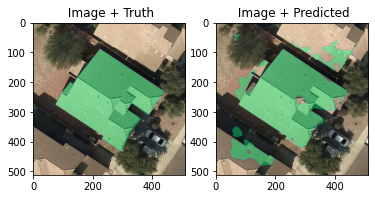

MeanIoU: 0.735  Precision: 0.765  Recall: 0.949  F1: 0.848


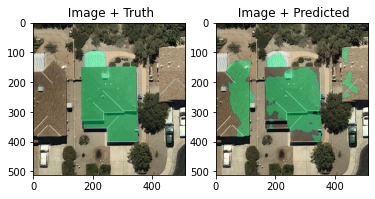

MeanIoU: 0.538  Precision: 0.651  Recall: 0.756  F1: 0.700


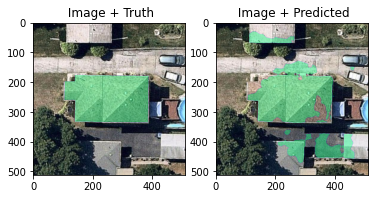

MeanIoU: 0.558  Precision: 0.617  Recall: 0.854  F1: 0.717


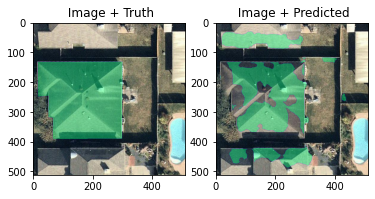

MeanIoU: 0.456  Precision: 0.643  Recall: 0.611  F1: 0.627


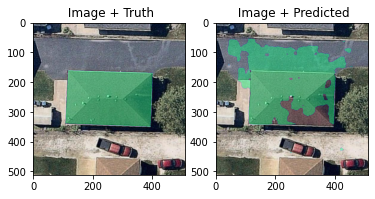

MeanIoU: 0.514  Precision: 0.582  Recall: 0.815  F1: 0.679


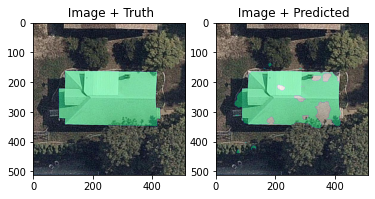

MeanIoU: 0.836  Precision: 0.960  Recall: 0.866  F1: 0.911


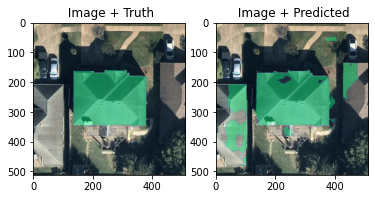

MeanIoU: 0.674  Precision: 0.693  Recall: 0.960  F1: 0.805


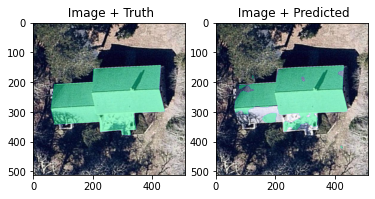

MeanIoU: 0.805  Precision: 0.994  Recall: 0.809  F1: 0.892


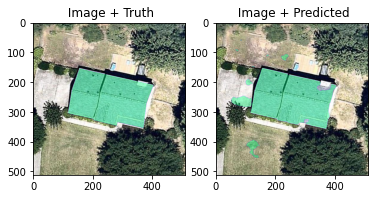

MeanIoU: 0.856  Precision: 0.888  Recall: 0.959  F1: 0.922


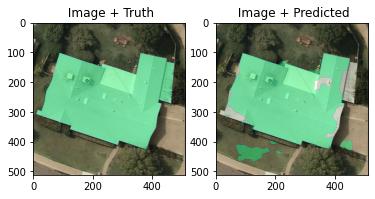

MeanIoU: 0.818  Precision: 0.923  Recall: 0.878  F1: 0.900


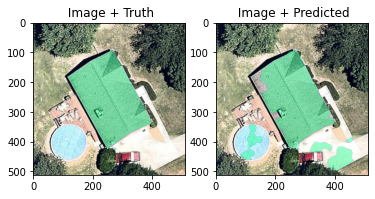

MeanIoU: 0.766  Precision: 0.809  Recall: 0.934  F1: 0.867


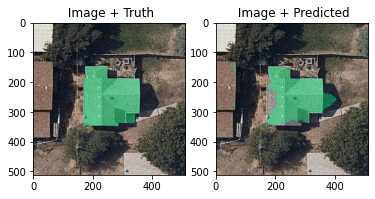

MeanIoU: 0.769  Precision: 0.917  Recall: 0.826  F1: 0.869


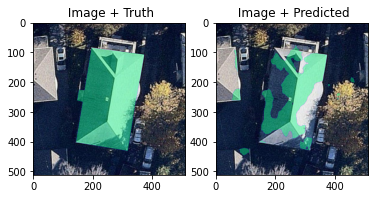

MeanIoU: 0.539  Precision: 0.920  Recall: 0.566  F1: 0.701


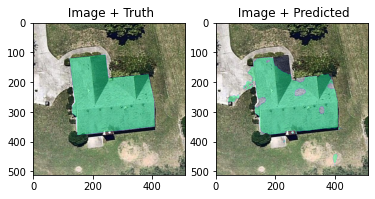

MeanIoU: 0.844  Precision: 0.940  Recall: 0.892  F1: 0.916


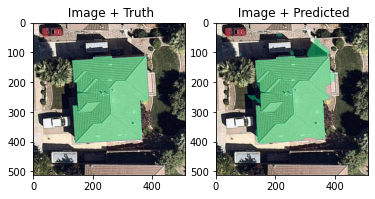

MeanIoU: 0.904  Precision: 0.923  Recall: 0.977  F1: 0.949


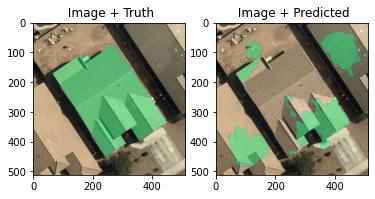

MeanIoU: 0.188  Precision: 0.403  Recall: 0.260  F1: 0.316


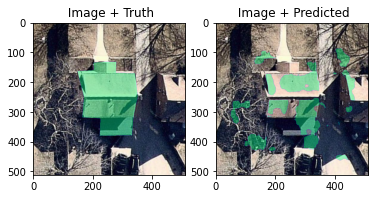

MeanIoU: 0.351  Precision: 0.545  Recall: 0.496  F1: 0.519


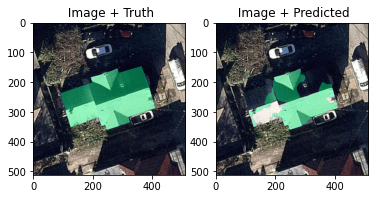

MeanIoU: 0.589  Precision: 0.988  Recall: 0.593  F1: 0.741


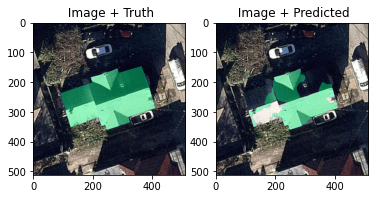

MeanIoU: 0.589  Precision: 0.988  Recall: 0.593  F1: 0.741


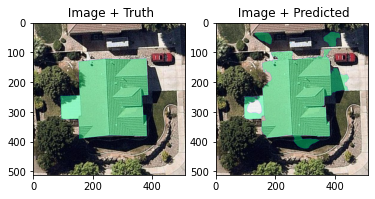

MeanIoU: 0.778  Precision: 0.829  Recall: 0.925  F1: 0.875


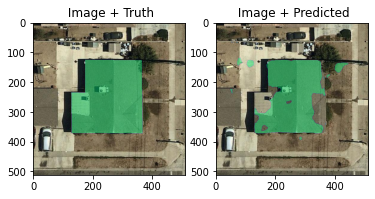

MeanIoU: 0.758  Precision: 0.950  Recall: 0.789  F1: 0.862


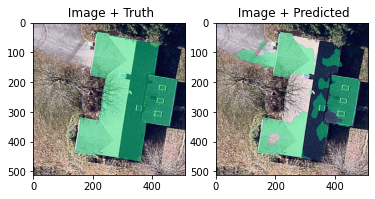

MeanIoU: 0.546  Precision: 0.895  Recall: 0.584  F1: 0.707


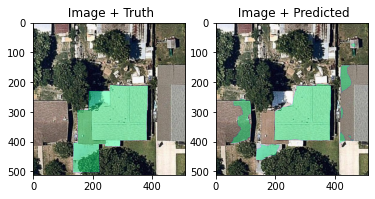

MeanIoU: 0.546  Precision: 0.770  Recall: 0.652  F1: 0.706


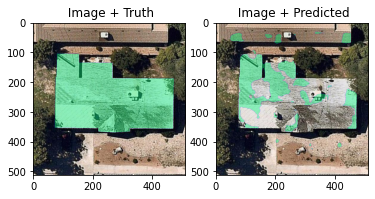

MeanIoU: 0.354  Precision: 0.878  Recall: 0.372  F1: 0.523


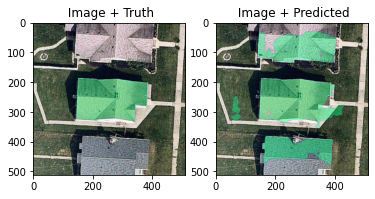

MeanIoU: 0.397  Precision: 0.401  Recall: 0.971  F1: 0.568


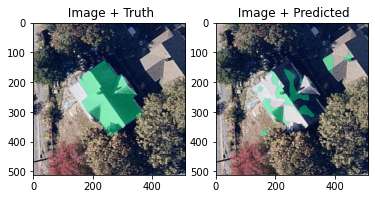

MeanIoU: 0.280  Precision: 0.713  Recall: 0.316  F1: 0.438


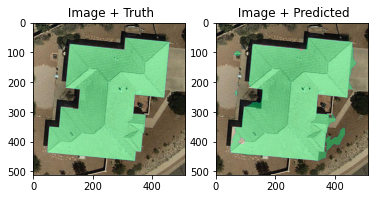

MeanIoU: 0.934  Precision: 0.944  Recall: 0.988  F1: 0.966


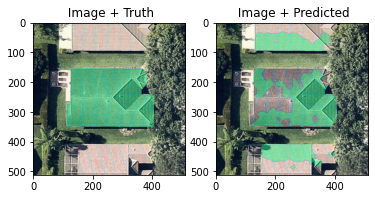

MeanIoU: 0.433  Precision: 0.585  Recall: 0.625  F1: 0.604


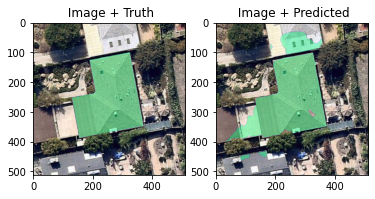

MeanIoU: 0.748  Precision: 0.762  Recall: 0.976  F1: 0.856


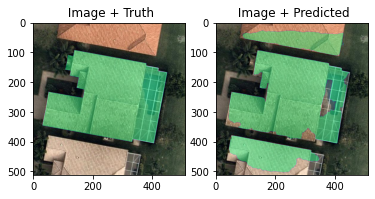

MeanIoU: 0.631  Precision: 0.676  Recall: 0.904  F1: 0.773


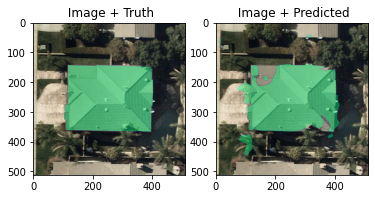

MeanIoU: 0.816  Precision: 0.894  Recall: 0.903  F1: 0.899


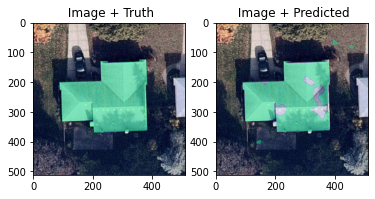

MeanIoU: 0.862  Precision: 0.986  Recall: 0.872  F1: 0.926


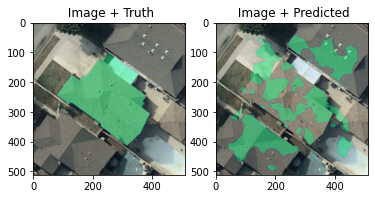

MeanIoU: 0.232  Precision: 0.332  Recall: 0.435  F1: 0.376
Final MeanIoU:   0.689
Final Precision: 0.781
Final Recall:    0.756
Final F1:        0.751


In [23]:
# let's check the output
avg_MIOU, avg_prec, avg_rec, avg_f1 = [], [], [], []
for ii, (x, y) in enumerate(zip(test_x, test_y)):
    x = read_data(Path(x), True)
    y = read_data(Path(y), True, 255., False)>0
    y_pred = model_diceLoss.predict(np.expand_dims(x, axis=0))[0] > 0.5
    y_pred = y_pred[:,:,0] # mask layer
    miou = np.logical_and(y, y_pred).sum()/np.logical_or(y, y_pred).sum()
    prec = precision_score(y.flatten(), y_pred.flatten())
    rec = recall_score(y.flatten(), y_pred.flatten())
    f1 = f1_score(y.flatten(), y_pred.flatten())
    if ii % 20 == 0:
        visualize_image_and_mask(x, y, y_pred)
        print(f'MeanIoU: {miou:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}')

    avg_MIOU.append(miou)
    avg_prec.append(prec)
    avg_rec.append(rec)
    avg_f1.append(f1)

print(f'Final MeanIoU:   {np.mean(avg_MIOU_dice):.3f}')
print(f'Final Precision: {np.mean(avg_prec):.3f}')
print(f'Final Recall:    {np.mean(avg_rec):.3f}')
print(f'Final F1:        {np.mean(avg_f1):.3f}')